<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%204/Series%20temporales/02_prediccion_series_temporales_DRNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes recurrentes profundas**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

**Notebook: Manuel Sánchez-Montañés**

**Datos: Carlos Rosado**

In [ ]:
COLAB = True

## <font color="#CA3532"> **1. Importar librerías**

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os
import urllib

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [ ]:
if COLAB:
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1HFc7SuPADQrPpsEk5yNxutt2iWC2GNvo",
                               "datos_pasajeros.csv")

data = pd.read_csv('datos_pasajeros.csv',sep=';')
data.head(20)

,fecha,mes,festivo,npasajeros,intensidad_evento,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week
0,2015-01-01,1,1,1125,0,0.0,0.000000,0,3
1,2015-01-02,1,0,3592,0,0.0,0.000000,0,4
2,2015-01-03,1,0,3001,0,0.0,0.000000,0,5
3,2015-01-04,1,0,2260,0,0.0,0.000000,0,6
4,2015-01-05,1,0,2767,0,0.0,0.000000,0,0
5,2015-01-06,1,1,1342,0,0.0,0.000000,0,1
6,2015-01-07,1,0,3867,0,0.0,0.000000,0,2
7,2015-01-08,1,0,3904,0,0.0,0.000000,1,3
8,2015-01-09,1,0,3678,0,0.0,0.000000,1,4
9,2015-01-10,1,0,2631,0,0.0,0.000000,1,5


In [ ]:
data.shape

(790, 9)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [ ]:
type(data['fecha'][0])

str

In [ ]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['fecha'] = pd.to_datetime(data['fecha'])
type(data['fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
fechas      = data['fecha'].values
target      = data['npasajeros'].values
lluvia      = data['inten_lluvia'].values
trafico     = data['ocupacion_trafico'].values
mes         = data['mes'].values
festivo     = data['festivo'].values
evento      = data['intensidad_evento'].values
semana      = data['semana_mes'].values
day_of_week = data['day_of_week'].values

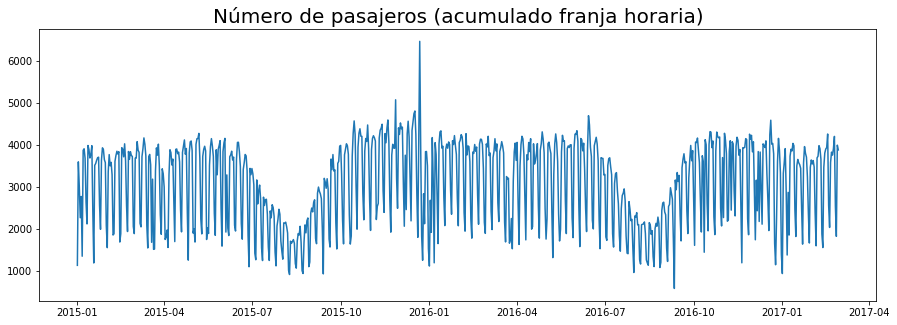

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Número de pasajeros (acumulado franja horaria)',
          fontsize=20);

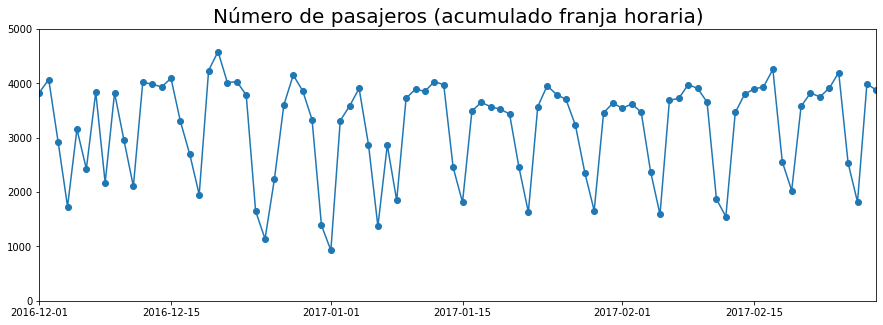

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Número de pasajeros (acumulado franja horaria)', fontsize=20)
#plt.axis([fechas[30],fechas[60],0,5000])
plt.axis([fechas[-90],fechas[-1],0,5000]);

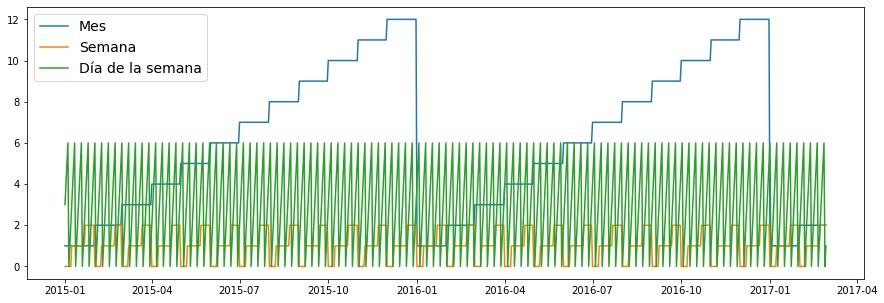

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, mes, label='Mes')
plt.plot(fechas, semana, label='Semana')
plt.plot(fechas, day_of_week, label='Día de la semana')
plt.legend(fontsize=14);

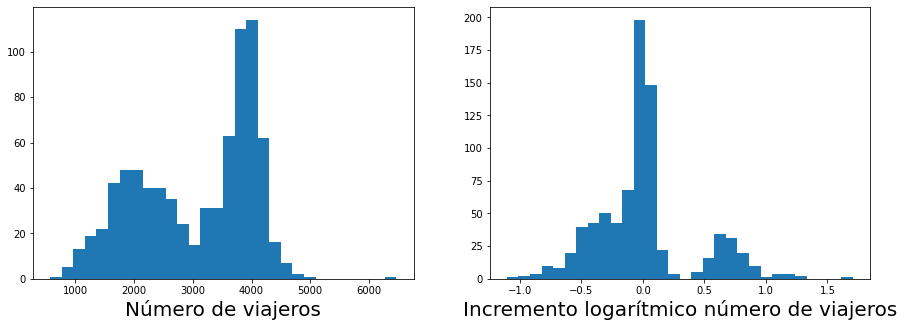

Media número de viajeros    : 3065.5784810126584
Media incremento logarítmico: 0.0015678335340584717


In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(target, bins=30)
plt.xlabel('Número de viajeros', fontsize=20)
plt.subplot(1,2,2)
aux = np.log( target[1:] / target[0:-1]  )
plt.hist(aux, bins=30)
plt.xlabel('Incremento logarítmico número de viajeros', fontsize=20)
plt.show()
print("Media número de viajeros    :", target.mean())
print("Media incremento logarítmico:", aux.mean())

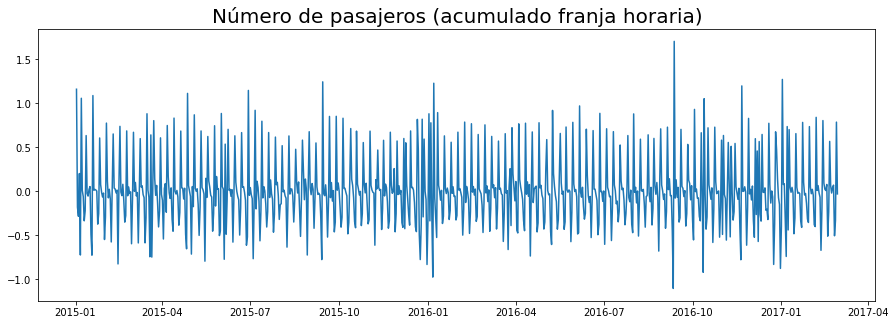

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas[1:], aux)
plt.title('Número de pasajeros (acumulado franja horaria)',
          fontsize=20);

In [ ]:
# x'(t) = log( x(t)/x(t-1) )
# x(t) =  x(t-1) * exp(x'(t))

## <font color="#CA3532"> **4. Transformación de la variable a predecir**

In [ ]:
eps = 1e-11

if COLAB:
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1FjOVsbuk72WaZqbd5e_uIFAM_GwX8hh3",
                               "my_utils_series_temporales.py")

from my_utils_series_temporales import NAN

# Transformación log ratios
def transform_logratios(x):
    aux = np.log((x[1:]+eps) / (x[0:-1]+eps))
    return np.hstack( ([NAN], x))
def inverse_transform_logratios(log_ratio_x, x_dia_anterior):
    return np.multiply(x_dia_anterior, np.exp(log_ratio_x))

# Transformación de escala (ajustar el factor en función del problema)
def transform_escala(x):
    return x/5000
def inverse_transform_escala(x_escalado, x_dia_anterior):
    return x_escalado*5000

# Transformación diff (ajustar el factor de escala en función del problema)
def transform_diffs(x):
    aux = (x[1:] - x[:-1]) / 5000
    return np.hstack( ([NAN], aux))
def inverse_transform_diffs(diffs, x_dia_anterior):
    return 5000*diffs + x_dia_anterior


In [ ]:
#transformacion = "logratios"
transformacion = "escala"
#transformacion = "diffs"

if transformacion == "logratios":
    transform = transform_logratios
    inverse_transform = inverse_transform_logratios
elif transformacion == "escala":
    transform = transform_escala
    inverse_transform = inverse_transform_escala
elif transformacion == "diffs":
    transform = transform_diffs
    inverse_transform = inverse_transform_diffs

transform(np.array([1,2,3]))

array([0.0002, 0.0004, 0.0006])

## <font color="#CA3532"> **5. Enventanado de datos**

In [ ]:
from my_utils_series_temporales import (int2dummy, enventanar,
                                        info_enventanado)


In [ ]:
#?int2dummy

In [ ]:
# en int2dummy el máximo marcado como entrada es un valor legal
one_hot_mes = int2dummy(mes, 1, 12)
one_hot_semana = int2dummy(semana, 0, 2)
one_hot_day_of_week = int2dummy(day_of_week, 0, 6)

In [ ]:
one_hot_mes

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
print(one_hot_day_of_week.shape, one_hot_mes.shape, one_hot_semana.shape)

(790, 7) (790, 12) (790, 3)


In [ ]:
target_transf = transform(target)

#series = [y, lluvia, trafico, festivo, evento]
#se_saben_antes = [False, False, False, True, True]
#nombres_series = ["y", "lluvia", "trafico", "festivo", "evento"]


series = [target_transf, festivo, evento]
se_saben_antes = [False, True, True]
nombres_series = ["target_transf", "festivo", "evento"]

#series = [y]
#se_saben_antes = [False]
#nombres_series = ["y"]

if True:
    for i in range(one_hot_mes.shape[1]):
        series.append(one_hot_mes[:,i])
        nombres_series.append("mes"+str(i+1))
        se_saben_antes.append(True)

    for i in range(one_hot_semana.shape[1]):
        series.append(one_hot_semana[:,i])
        nombres_series.append("semana"+str(i+1))
        se_saben_antes.append(True)

    for i in range(one_hot_day_of_week.shape[1]):
        series.append(one_hot_day_of_week[:,i])
        nombres_series.append("day"+str(i+1))
        se_saben_antes.append(True)

In [ ]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(25, 790)
(25,)


In [ ]:
lookback = 2 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(790, 2, 25) (790,)


In [ ]:
# Otro truco para pasar de variables categóricas cíclicas a 2 variables (y así evitarte dummies):
#
# mes1 = cos((MES-1)/12 * 2*pi)  # MES va de 1 a 12
# mes2 = sin((MES-1)/12 * 2*pi)  # MES va de 1 a 12

# dia1 = cos(DIA_SEMANA/7 * 2*pi)  # DIA_SEMANA va de 0 a 6
# dia2 = sin(DIA_SEMANA/7 * 2*pi)  # DIA_SEMANA va de 0 a 6

In [ ]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target_transf",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 2, 25)  Y.shape=(10,) 

 Ventana 0: 


,?0,?1
target_transf,nan,nan
festivo,nan,1.000000
evento,nan,0.000000
mes1,nan,1.000000
mes2,nan,0.000000
mes3,nan,0.000000
mes4,nan,0.000000
mes5,nan,0.000000
mes6,nan,0.000000
mes7,nan,0.000000


 Ventana 1: 


,?0,2015-01-01T00:00:00.000000000
target_transf,nan,0.225000
festivo,1.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 2: 


,2015-01-01 00:00:00,2015-01-02 00:00:00
target_transf,0.225000,0.718400
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 3: 


,2015-01-02 00:00:00,2015-01-03 00:00:00
target_transf,0.718400,0.600200
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 4: 


,2015-01-03 00:00:00,2015-01-04 00:00:00
target_transf,0.600200,0.452000
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 5: 


,2015-01-04 00:00:00,2015-01-05 00:00:00
target_transf,0.452000,0.553400
festivo,0.000000,1.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 6: 


,2015-01-05 00:00:00,2015-01-06 00:00:00
target_transf,0.553400,0.268400
festivo,1.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 7: 


,2015-01-06 00:00:00,2015-01-07 00:00:00
target_transf,0.268400,0.773400
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 8: 


,2015-01-07 00:00:00,2015-01-08 00:00:00
target_transf,0.773400,0.780800
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


 Ventana 9: 


,2015-01-08 00:00:00,2015-01-09 00:00:00
target_transf,0.780800,0.735600
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,1.000000,1.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


In [ ]:
print(X.shape)
print(np.shape(target))

(790, 2, 25)
(790,)


## <font color="#CA3532"> **6. Separación training-test**

In [ ]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [ ]:
X_train = X[(lookback+1):punto_corte]
y_train = y[(lookback+1):punto_corte]
target_train = target[(lookback+1):punto_corte]
target_test  = target[punto_corte:]
X_test  = X[punto_corte:]
y_test  = y[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(629,)
(158,)


In [ ]:
target_diaant_train =  np.hstack(( [NAN], target_train[:-1]))
target_diaant_test  =  np.hstack(( target[-1:], target_test[:-1]))
fechas_train     = fechas[(lookback+1):punto_corte]
fechas_test      = fechas[punto_corte:]

In [ ]:
print(X_train.shape, y_train.shape)

(629, 2, 25) (629,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape=(lookback, X_train.shape[2]),
#              kernel_regularizer='l1'
              )
         )
model.add(Dense(1,
#                kernel_regularizer='l1'
               )
         )
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']) # 'RMSprop'
# mean_absolute_error

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [ ]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1440      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
OS_WINDOWS = False

# Creación del directorio log en el que se va a grabar
# el grafo del modelo y resultados intermedios del proceso
# de training para visualizarlo luego en Tensorboard

log_path = 'log/'

tb_callback = TensorBoard(
    log_dir=log_path,
    histogram_freq=2,
    write_graph=True
)
tb_callback.set_model(model)
callbacks = []
callbacks.append(tb_callback)

# A continuación se trata de crear el directorio log:
# - Si no existe se crea
# - Si ya existe se borran los datos que haya dentro de él

try:
    os.mkdir(log_path)
except:
    if OS_WINDOWS:
        !del log\*
    else:
        !rm log/*

rm: cannot remove 'log/train': Is a directory


Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: val_mse improved from inf to 0.24411, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.24411 to 0.20080, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.20080 to 0.16421, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.16421 to 0.13409, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.13409 to 0.11018, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.11018 to 0.09161, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.09161 to 0.07740, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.07740 to 0.06688, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.06688 to 0.05905, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.05905 to 0.05278, saving model to model_current_

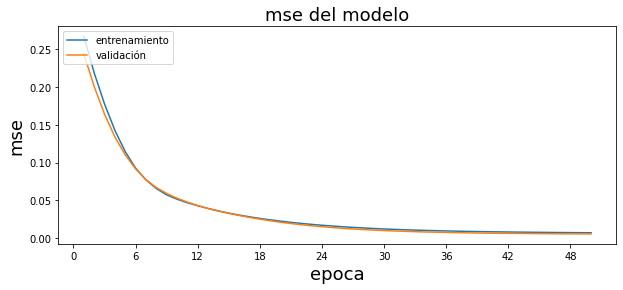


Epoch 00001: val_mse improved from 0.00542 to 0.00536, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00536 to 0.00525, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00525 to 0.00524, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00524 to 0.00517, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00517

Epoch 00001: val_mse improved from 0.00517 to 0.00516, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00516 to 0.00507, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00507 to 0.00497, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00497

Epoch 00001: val_mse did not improve from 0.00497

Epoch 00001: val_mse did not improve from 0.00497

Epoch 00001: val_mse did not improve from 0.00497

Epoch 00001: val_mse improved from 0.00497 to 0.00490, saving model to model_current_b

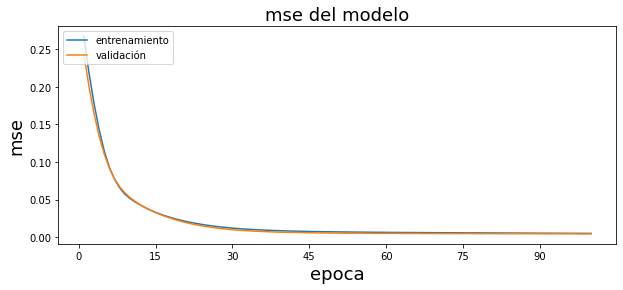


Epoch 00001: val_mse did not improve from 0.00424

Epoch 00001: val_mse did not improve from 0.00424

Epoch 00001: val_mse did not improve from 0.00424

Epoch 00001: val_mse improved from 0.00424 to 0.00421, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00421 to 0.00416, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse did not improve from 0.00416

Epoch 00001: val_mse improved from 0.00416 to 0.00411, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00411 to 0.00409, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00409

Epoch 00001: val_mse improved from 0.00409 to 0.00408, saving 

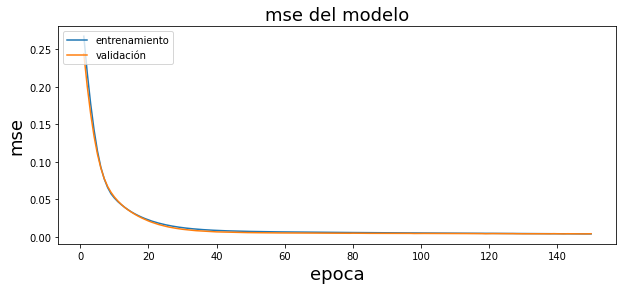


Epoch 00001: val_mse did not improve from 0.00373

Epoch 00001: val_mse improved from 0.00373 to 0.00368, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse improved from 0.00368 to 0.00368, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse did not improve from 0.00368

Epoch 00001: val_mse improved from 0.00368 to 0.00363, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00363

Epoch 00001: val_mse did not improve from 0.00363

Epoch 00001: val_mse did not improve from 0.00363

Epoch 00001: val_mse did not improve from 0.00363

Epoch 00001: val_mse did not improve from 0.00363

Epoch 00001: val_mse did not improve from 0.00363

Epo

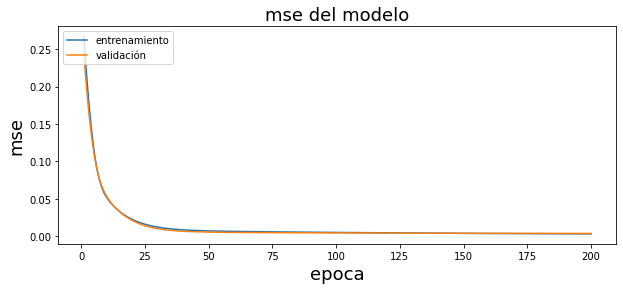

In [ ]:
epochs = 200
batch_size = 64
Nval = 200
control_sobreajuste_val = True
grabar_detalles_training_para_tensorboard = True
# si no se van a analizar estos detalles en tensorboard mejor
# poner este flag a False ya que el grabarlos enlentence
# bastante el training

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    filepath="model_current_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    if grabar_detalles_training_para_tensorboard:
        callbacks_list = callbacks + [checkpoint]
    else:
        callbacks_list = [checkpoint]
    
    for e in range(epochs):
        history = model.fit(X_train[:-Nval], y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [ ]:
model = load_model('model_current_best.h5')

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [ ]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()

In [ ]:
target_train_pred = inverse_transform(y_train_prediction, target_diaant_train)
target_test_pred  = inverse_transform(y_test_prediction,  target_diaant_test)

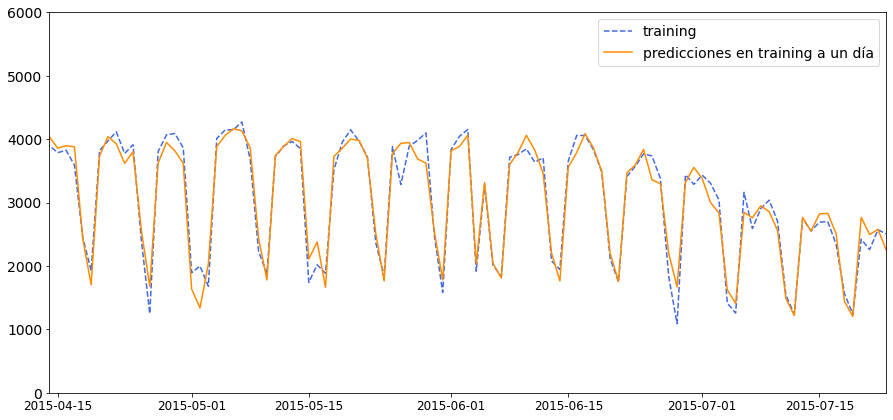

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[100],fechas_train[200],0,6000])
plt.legend(fontsize=14);

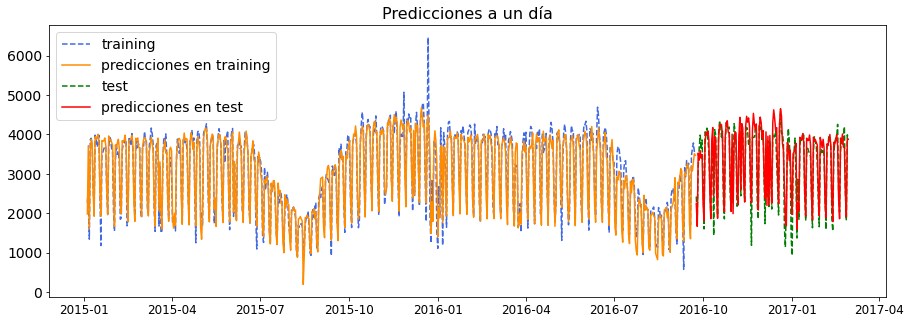

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

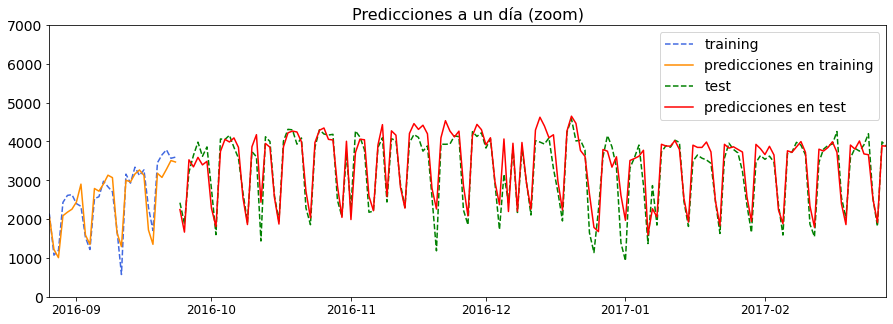

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[600],fechas_test[-1],0,7000]);

In [ ]:
# Modelos de referencia (en orden de complejidad):
# 1- Predecir siempre media (mediana) en training
# 2- Modelo persistente (a 1 día, 7 días etc.)
# 3- SARIMAX


# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.9191418771816617
R2 del modelo en test          :  0.8494604960042931
R2 modelo persistente 1 día    :  -0.44768351889101354
R2 modelo persistente 1 semana :  0.3743300534633949
R2 modelo persistente 4 semanas:  0.48525679455105053
R2 modelo persistente 1 año:  0.6730265954308865


In [ ]:
# RMSEs
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  287.2991159994067
RMSE del modelo en test          :  352.5706635320165
RMSE modelo persistente 1 día    :  1093.8023843688381
RMSE modelo persistente 1 semana :  724.5713553588926
RMSE modelo persistente 4 semanas:  654.1568971996292


## <font color="#CA3532"> **9. Predicciones a varios días en test mediante un modelo generativo**

In [ ]:
def step_generativo(model, semilla, X, i, target_dia_anterior):
    z = model.predict(semilla)[0,0]
    target_pred = inverse_transform(z, target_dia_anterior)
    semilla_nueva = None
    if i < (len(X)-1):
        semilla_nueva = semilla.copy()
        semilla_nueva[0,:-1,:] = semilla[0,1:,:].copy()
        semilla_nueva[0,-1,0] = z
        semilla_nueva[0,-1,1:] = X[i+1,-1,1:]
        
    return target_pred, semilla_nueva

In [ ]:
def generativo(model, X, target_dia_anterior):
    semilla = np.array([X[0]]).copy()    
    salidas = []
    for i in range(len(X)):
        target_pred, semilla_nueva = step_generativo(model, semilla, X, i,
                                                     target_dia_anterior)
        salidas.append(target_pred)
        
        target_dia_anterior = target_pred
        semilla = semilla_nueva
    
    return salidas

In [ ]:
sal = generativo(model, X_test, target_diaant_test[0])

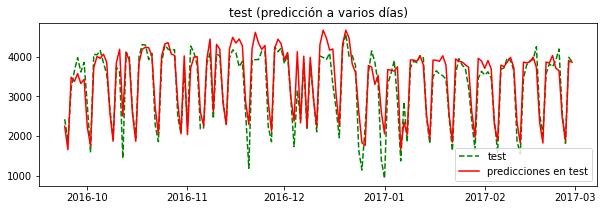

In [ ]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_test, target_test, '--g', label='test')
plt.plot(fechas_test, sal, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();
#plt.axis([660,680,0,4500]);

In [ ]:
if grabar_detalles_training_para_tensorboard:
    import webbrowser
    if COLAB:
        %load_ext tensorboard
        %tensorboard --logdir $log_path
    else:
        webbrowser.open_new('http://localhost:6006')
        os.system('tensorboard --logdir=' + log_path)

### **"Heatmaps" de la predicción: ¿qué inputs han influido más en la predicción?**

In [ ]:
print(nombres_series)
print(len(nombres_series))
print(X_test.shape)

['target_transf', 'festivo', 'evento', 'mes1', 'mes2', 'mes3', 'mes4', 'mes5', 'mes6', 'mes7', 'mes8', 'mes9', 'mes10', 'mes11', 'mes12', 'semana1', 'semana2', 'semana3', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']
25
(158, 2, 25)


In [ ]:
len(se_saben_antes)

25

In [ ]:
i = 0
print(fechas_test[i]) # 24/09/2016 fue sábado
sample = X_test[i:(i+1)].copy()
sample.shape

2016-09-24T00:00:00.000000000


(1, 2, 25)

In [ ]:
info_enventanado(X_test[i:(i+1)],y[i:(i+1)],
                 nombres_series=nombres_series,
                 nombre_target="target_transf",
                 tiempos=fechas_test[i:(i+1)])

1 ventanas creadas

X.shape=(1, 2, 25)  Y.shape=(1,) 

 Ventana 0: 


,?0,?1
target_transf,0.713400,0.719400
festivo,0.000000,0.000000
evento,0.000000,0.000000
mes1,0.000000,0.000000
mes2,0.000000,0.000000
mes3,0.000000,0.000000
mes4,0.000000,0.000000
mes5,0.000000,0.000000
mes6,0.000000,0.000000
mes7,0.000000,0.000000


In [ ]:
pred0 = model.predict(sample)[0][0]
delta = 1e-3
w_in = sample.shape[1]

print("SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:")
for i,x in enumerate(nombres_series):
    for j in range(w_in):
        sample_pert = sample.copy()
        sample_pert[0,j,i] += delta
        pred_pert = model.predict(sample_pert)[0][0]
        if se_saben_antes[i]:
            print("{} (t-{}) [ADELANTADA]: {}".format(x, w_in-j, (pred_pert - pred0) / delta))
        else:
            print("{} (t-{}): {}".format(x, w_in-j, (pred_pert - pred0) / delta))

SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:
target_transf (t-2): 0.0521242618560791
target_transf (t-1): 0.09015202522277832
festivo (t-2) [ADELANTADA]: 0.0006556510925292969
festivo (t-1) [ADELANTADA]: -0.3247261047363281
evento (t-2) [ADELANTADA]: 0.00908970832824707
evento (t-1) [ADELANTADA]: -0.0006854534149169922
mes1 (t-2) [ADELANTADA]: 0.046372413635253906
mes1 (t-1) [ADELANTADA]: 0.12069940567016602
mes2 (t-2) [ADELANTADA]: 0.04431605339050293
mes2 (t-1) [ADELANTADA]: 0.061392784118652344
mes3 (t-2) [ADELANTADA]: 0.008702278137207031
mes3 (t-1) [ADELANTADA]: 0.057220458984375
mes4 (t-2) [ADELANTADA]: 0.024586915969848633
mes4 (t-1) [ADELANTADA]: 0.12874603271484375
mes5 (t-2) [ADELANTADA]: 0.05570054054260254
mes5 (t-1) [ADELANTADA]: 0.04038214683532715
mes6 (t-2) [ADELANTADA]: 0.03904104232788086
mes6 (t-1) [ADELANTADA]: 0.030338764190673828
mes7 (t-2) [ADELANTADA]: -0.018864870071411133
mes7 (t-1) [ADELANTADA]: -0.06601214408874512
mes8 (t-2) [ADELANTADA]: -0.10430812835693

### **Función que saca por pantalla todos los parámetros de todas las capas de la red**

In [ ]:
def info_red(modelo):
    for i,layer in enumerate(modelo.layers):
        print('* Capa {} [Nombre: "{}"]'.format(i,layer.name))
        print('  Tipo:', type(layer))
        print("  Propiedades:")
        aux = layer.get_config()
        for k in aux:
            print("    {}: {}".format(k, aux[k]))
        print()

In [ ]:
info_red(model)

* Capa 0 [Nombre: "lstm"]
  Tipo: <class 'tensorflow.python.keras.layers.recurrent_v2.LSTM'>
  Propiedades:
    name: lstm
    trainable: True
    batch_input_shape: (None, 2, 25)
    dtype: float32
    return_sequences: False
    return_state: False
    go_backwards: False
    stateful: False
    unroll: False
    time_major: False
    units: 10
    activation: tanh
    recurrent_activation: sigmoid
    use_bias: True
    kernel_initializer: {'class_name': 'GlorotUniform', 'config': {'seed': None}}
    recurrent_initializer: {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}
    bias_initializer: {'class_name': 'Zeros', 'config': {}}
    unit_forget_bias: True
    kernel_regularizer: None
    recurrent_regularizer: None
    bias_regularizer: None
    activity_regularizer: None
    kernel_constraint: None
    recurrent_constraint: None
    bias_constraint: None
    dropout: 0.0
    recurrent_dropout: 0.0
    implementation: 2

* Capa 1 [Nombre: "dense"]
  Tipo: <class 